# Stock Valuation - Intel Corp.

This notebook contains a simple evaluation of the `Intel` (yahoo ticker: `INTC`) stock. The evaluation is conducted by using the `value-investing-in-python` project.

## Preliminaries

In [1]:
import pandas as pd
import numpy as np

The following commands are necessary to use the 'value-investing-in-python' project as package.

In [2]:
import sys
sys.path.append('../')
sys.path.append('../src')

## Get data

In [3]:
from database.morningstar_scraper import MorningstarScraper
from database.yahoo_finance_scraper import YahooFinanceScraper
from database.damodaran_scraper import DamodaranScraper

In [4]:
from utils.data_interval import DataInterval

Scraping the **Morningstar identifier** does not work properly because of the dynamic JavaScript content on the webpage. Hence, identifier has to be extracted manually by inspecting the page content.

In [5]:
# morningstar_identfier = MorningstarScraper.scrape_morningstar_stock_identifier('INTC', 'XNAS')

In [6]:
# morningstar_dataset = MorningstarScraper.scrape_and_combine_morningstar_data('0P000002X8', 20.0)

In [7]:
morningstar_dataset = pd.read_csv('intc.csv', index_col=0)

Some important metrics (especially free cash flow) are missing. Hence, in the following we will try to approximate them by using other metrices.

In [8]:
morningstar_dataset.loc['shares_mil'] = morningstar_dataset.loc['free_cash_flow_mil'] / morningstar_dataset.loc['free_cash_flow_to_shares']

In [9]:
morningstar_dataset.loc['free_cash_flow_mil'] = morningstar_dataset.loc['free_cash_flow_to_revenue'] / 100.0 * morningstar_dataset.loc['revenue_mil']

Latest equity ratio is approx. 4,000 percent, which is an unreasonable result. The equity ratio cannot be approximated properly and hence set to NaN.

In [10]:
morningstar_dataset.loc['equity_ratio_pct'] = np.nan

Scrape price data for Nike stock and the S&P 500 (benchmark):

In [11]:
one_day_interval = DataInterval.ONE_DAY

In [12]:
# intc_prices = YahooFinanceScraper.scrape_price_data('INTC', 'max', one_day_interval)

In [13]:
intc_prices = pd.read_csv('intc_prices.csv', index_col=0)

In [14]:
# sp500_prices = YahooFinanceScraper.scrape_price_data('^GSPC', 'max', one_day_interval)

In [15]:
sp500_prices = pd.read_csv('sp500_prices.csv', index_col=0)

Scrape data provided by Prof. Damodaran:

In [16]:
spreads, risk_premiums = DamodaranScraper.scrape_data()

In [17]:
spreads_nonfin, spreads_fin, premiums = DamodaranScraper.modify_damodaran_data(spreads, risk_premiums)

## Evaluate data

In [18]:
from evaluation.evaluator import Evaluator

In [19]:
from utils.assessment_period import AssessmentPeriod

### Plot metric development

In [20]:
ten_years_period = AssessmentPeriod.TEN_YEARS

In [21]:
morningstar_dataset_transposed = morningstar_dataset.T

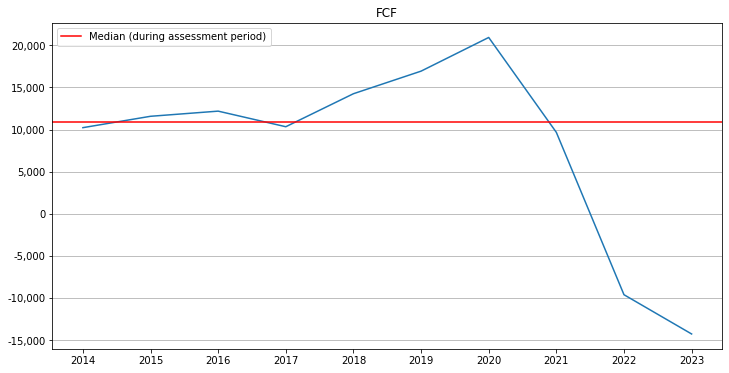

In [24]:
Evaluator.plot_metric_development(morningstar_dataset_transposed['free_cash_flow_mil'], ten_years_period, 'FCF')

In [25]:
margins = [morningstar_dataset_transposed['gross_margin_pct'], morningstar_dataset_transposed['net_margin_pct'],
           morningstar_dataset_transposed['operating_margin_pct']]

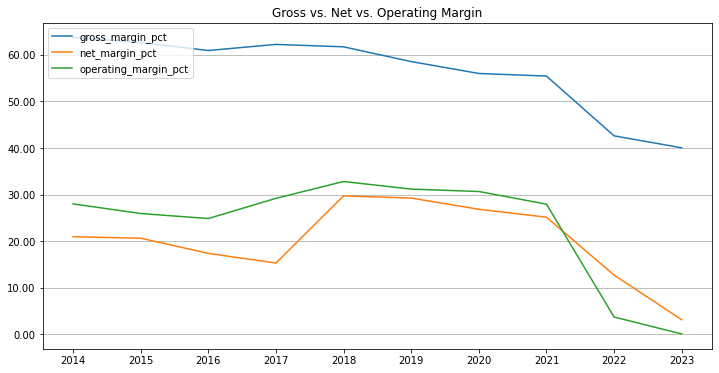

In [26]:
Evaluator.plot_metric_development_comparison(margins, ten_years_period, 'Gross vs. Net vs. Operating Margin')

In [27]:
returns = [morningstar_dataset_transposed['return_on_assets_pct'], morningstar_dataset_transposed['return_on_equity_pct'],
           morningstar_dataset_transposed['return_on_invested_capital_pct']]

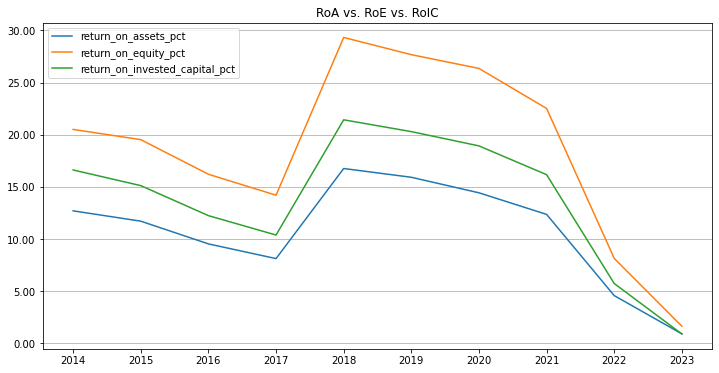

In [28]:
Evaluator.plot_metric_development_comparison(returns, ten_years_period, 'RoA vs. RoE vs. RoIC')

### Assess metric development

In [29]:
median_growth_rates, median_values = Evaluator.assess_metrics(morningstar_dataset_transposed)

In [30]:
median_growth_rates.round(3)

,10Y,3Y,1Y,points
revenue_mil,0.040,-0.127,-0.140,1
operating_income_mil,-0.008,-0.893,-0.987,0
net_income_mil,-0.035,-0.582,-0.789,0
eps,-0.005,-0.584,-0.794,0
dividends,0.060,-0.063,-0.493,1
bvps,0.091,0.093,-0.003,2
operating_cash_flow_mil,0.027,-0.326,-0.257,1
free_cash_flow_mil,0.089,NaN,NaN,1
capex_mil,0.142,0.222,0.028,3


In [31]:
median_values.round(2)

,10Y,3Y,1Y,points
payout_ratio,40.08,75.26,185.00,2
interest_coverage_ratio,39.11,16.66,1.87,3
operating_margin_pct,27.97,3.70,0.06,1
net_margin_pct,20.79,12.71,3.11,2
gross_margin_pct,59.75,42.61,40.04,3
return_on_equity_pct,20.02,8.14,1.63,2
return_on_assets_pct,12.04,4.57,0.90,1
return_on_invested_capital_pct,15.64,5.73,0.89,1
free_cash_flow_to_revenue,19.20,-15.25,-26.33,1
current_ratio,1.73,1.57,1.54,3


### Cumulative returns (during last year)

In [32]:
from beta.beta_estimator import BetaEstimator

In [33]:
intc_returns_last_year = BetaEstimator.calculate_cumulative_returns(intc_prices[-253:])

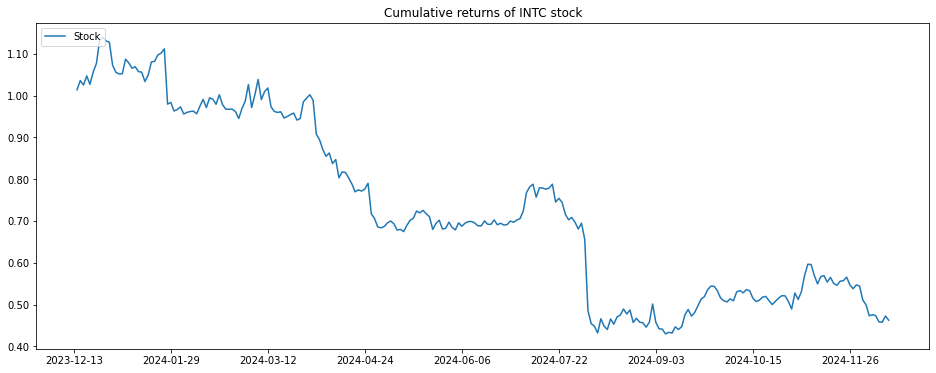

In [34]:
Evaluator.plot_cumulative_returns('INTC', intc_returns_last_year)

## Estimate intrinsic value

In [35]:
from intrinsic_value.discount_rate_estimator import DiscountRateEstimator
from intrinsic_value.growth_rate_calculator import GrowthRateCalculator
from intrinsic_value.intrinsic_value_estimator import IntrinsicValueEstimator

In [36]:
from utils.company_type import CompanyType
from utils.company_region import CompanyRegion
from utils.data_frequency import DataFrequency

### Beta estimation

In [37]:
daily_data = DataFrequency.DAILY

In [38]:
intc_beta = BetaEstimator.estimate_beta(intc_prices, sp500_prices, ten_years_period, daily_data)

In [39]:
intc_beta

0.15291696668945035

### Discount rate estimation

In [40]:
intc_comp_type = CompanyType.NON_FINANCIAL

In [41]:
intc_comp_region = CompanyRegion.NORTH_AMERICA

In [42]:
discount_rate = DiscountRateEstimator.estimate_discount_rate(morningstar_dataset_transposed, spreads_nonfin, spreads_fin,
                                                             premiums, 0.0, intc_beta, intc_comp_type, intc_comp_region,
                                                             ten_years_period)

Equity ratio NaN. Return NaN.


In [43]:
discount_rate

nan

Estimated discount rate is NaN, because the equity ratio is NaN (no sufficient data provided by Morningstar).

### Growth rate estimation

In [44]:
free_cash_flow_series = morningstar_dataset_transposed['free_cash_flow_mil']

In [45]:
growth_rate = GrowthRateCalculator.calculate_median_cagr(free_cash_flow_series, ten_years_period)

In [46]:
print(f'Growth rate is {round(growth_rate * 100.0, 0)} %')

Growth rate is 9.0 %


### Intrinsic value

In [47]:
current_shares = morningstar_dataset_transposed['shares_mil'].iloc[-1]

In [48]:
disc_rates = [0.06, 0.07, 0.08, 0.09, 0.10]

In [49]:
terminal_gr = 0.02

In [50]:
intrinsic_values = IntrinsicValueEstimator.apply_discounted_cash_flow_model(free_cash_flow_series, current_shares,
                                                                            growth_rate, disc_rates, terminal_gr, 10)

Add column with intrinsic value reduced by 20 percent margin of safety:

In [51]:
intrinsic_values['IV after MoS'] = intrinsic_values['IV_DCF'] * 0.8

In [52]:
intrinsic_values

,IV_DCF,IV after MoS
6.0 %,86.243258,68.994606
7.0 %,66.750050,53.400040
8.0 %,53.915634,43.132507
9.0 %,44.870341,35.896273
10.0 %,38.181133,30.544906


Inspect the intrinsic value and the price development over the last year.

Latest adjusted close price: 20.34

Intrinsic value (after Margin of Safety): 24.44

Stock is undervalued! Difference is equal to: 4.1


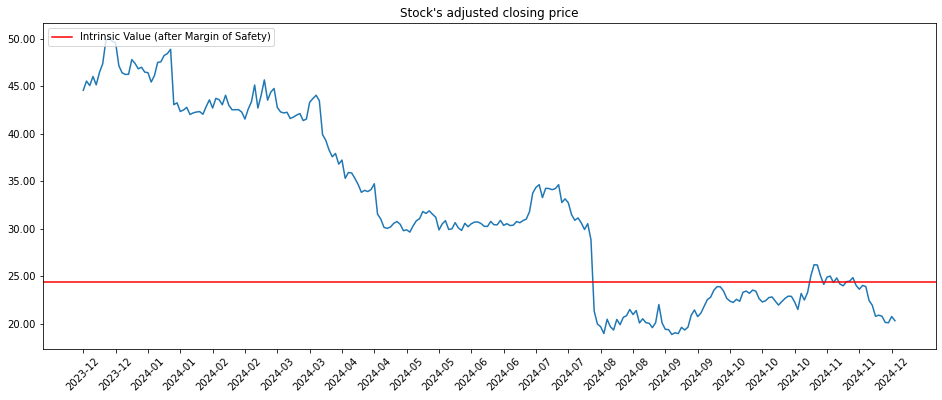

In [60]:
Evaluator.assess_intrinsic_value(intc_prices[-252:], intrinsic_values.iloc[4, 1], 0.2)

### Scores

In [61]:
hrlr_score = Evaluator.get_hrlr_score(intc_prices, sp500_prices, 0.0)

1-Year Beta: -2.23
Momentum: -54.38%
1-Year Dividend Yield: 0.0%
Overall score: 1/3


In [62]:
f_score = Evaluator.get_piotroski_f_score(morningstar_dataset_transposed)

Piotroski F-Score: 3/9
